In [509]:
import pandas as pd
import os
from os.path import isfile, join
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh, inv, eigvals, eigh, eig, norm
import scipy
import yfinance as yf


In [510]:
data_dir = r'D:\data\iqfeed\daily\cleaned'

In [553]:
onlyfiles = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]

In [554]:
sp_assets = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = sp_assets['Symbol'].str.replace('.', '-').tolist()

In [555]:
dfs = []
for f in onlyfiles:
    try:
        f_name = f.split('.')[0]
        ticker = f.split('_')[0]        
        if ticker not in sp500_tickers: 
            continue
        prices_path = os.path.join(data_dir, f)
        prices = pd.read_parquet(prices_path, columns=['adj_close'])
        prices.columns = [ticker]
        dfs.append(prices)
    except Exception as e:
        continue

In [556]:
dfs = pd.concat(dfs, axis=1)
#dfs.columns = range(dfs.shape[1])

In [557]:
dfs.sort_index(inplace=True)

In [558]:
dfs.head()

,FITB,BWA,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBRA,ZBH,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,6.767463,12.552887,NaN,6.486264,NaN,NaN,19.141501,7.994444,32.455263,37.0800,...,NaN,10.007792,41.675920,13.063946,40.599995,NaN,19.237621,28.6700,52.703501,NaN
2010-01-05,6.941159,13.166039,NaN,6.488080,NaN,NaN,18.972996,7.967778,32.671271,37.7400,...,NaN,10.208897,44.227773,12.890503,40.782058,NaN,19.188128,28.6200,54.301109,NaN
2010-01-06,6.954520,13.637980,NaN,6.384240,NaN,NaN,19.088542,7.933333,33.002998,37.6104,...,NaN,10.104955,43.614287,12.933864,41.122692,NaN,19.041296,28.4000,54.380112,NaN
2010-01-07,7.395440,13.827500,NaN,6.375157,NaN,NaN,19.247102,7.886667,32.987569,36.9300,...,NaN,10.057503,44.533735,12.865725,40.993486,NaN,19.056440,27.7547,55.626597,NaN
2010-01-08,7.395440,13.556226,NaN,6.415119,NaN,NaN,19.356041,7.871111,32.840992,36.7000,...,NaN,9.958984,44.221263,12.890503,40.829042,NaN,19.078388,27.6000,54.353778,NaN


In [564]:
dfs = dfs.apply(lambda x: np.log(x).diff())

In [565]:
def remove_market_component(C):
    eig_vals, eig_vecs = eigh(C)
    eig_vals[-1] = 0
    resid_C = eig_vecs @ np.diag(eig_vals) @ eig_vecs.T
    return resid_C

In [569]:
def my_f(X):
    C = X.dropna(axis=1).to_numpy().T @ X.dropna(axis=1).to_numpy()
    return np.array([np.trace(C)/C.shape[0], np.linalg.norm(C, ord='fro')/C.shape[0]])

In [572]:
def rolling_pipe(dataframe, window, fctn):
    return pd.DataFrame(
        data=np.stack(
            [dataframe.iloc[i-window: i].pipe(fctn) if i >= window else np.array([np.nan, np.nan]) for i in range(1, len(dataframe)+1)], 
            axis=0),
        columns=["Trace", "Frob"],
        index = dataframe.index)

In [606]:
dfs = dfs.where(np.abs(dfs) < 1, other=0)

In [607]:
c_props = dfs.iloc[-2000:, :].pipe(rolling_pipe, 5, my_f)

<Axes: xlabel='date'>

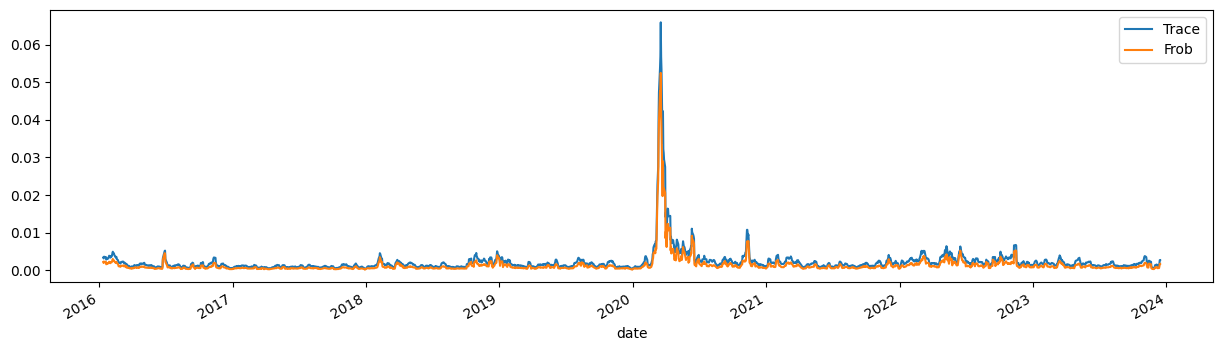

In [609]:
c_props.plot(figsize=(15, 4))

In [810]:
cutoff = -3000
X = (dfs.iloc[cutoff:].isna()).sum(axis=0) < 10
df = dfs.iloc[cutoff:, ].loc[:, X]
df = df.dropna()
df.shape

(3000, 489)

In [811]:
C = df.T @ df / df.shape[0] * np.sqrt(252)

In [867]:
def stieltjes_transform(z, eig_vals, N):
    return (1/N) * sum(1/(z-eig_vals))

def estimated_density(x, eig_vals, N):
    eta = 1/(np.sqrt(N))
    return (stieltjes_transform(x - eta*1j, eig_vals, N)/np.pi).imag

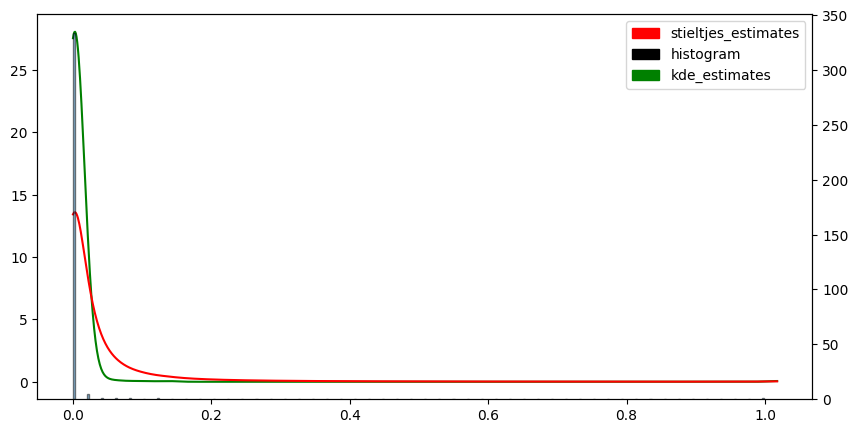

In [893]:
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
eig_vals, eig_vecs = eigh(C)
EVS = eig_vals
kernel = scipy.stats.gaussian_kde(EVS)
xs = np.linspace(0.0001, max(EVS), 1000)

kde_estimates = np.reshape(kernel(xs).T, xs.shape)
stieltjes_estimates = [estimated_density(x, EVS, C.shape[0]) for x in xs]

labels = {
    'stieltjes_estimates':'red',
    'histogram':'k',
    'kde_estimates': 'green'
}

_ = ax.plot(xs, kde_estimates, color=labels['kde_estimates'], label='kde_estimates')
_ = ax.plot(xs, stieltjes_estimates, color=labels['stieltjes_estimates'], label="stieltjes_estimates")
ax2 = ax.twinx()

filtered_eigs = eig_vals[eig_vals > 0.001]
h, e = np.histogram(filtered_eigs, bins=50)

ax2.bar(e[:-1], h, width=0.003, edgecolor=labels['histogram'], alpha=0.5, label="histogram")
#ax2.set_yscale('log')

ax.legend(
    labels = list(labels.keys()),
    handles = [plt.Rectangle((0,0),1,1, color=labels[label]) for label in labels])



In [869]:
eig_vals, eig_vecs = eigh(C)
eig_vals[-1] = 0
C_tilde = eig_vecs @ np.diag(eig_vals) @ np.linalg.inv(eig_vecs)

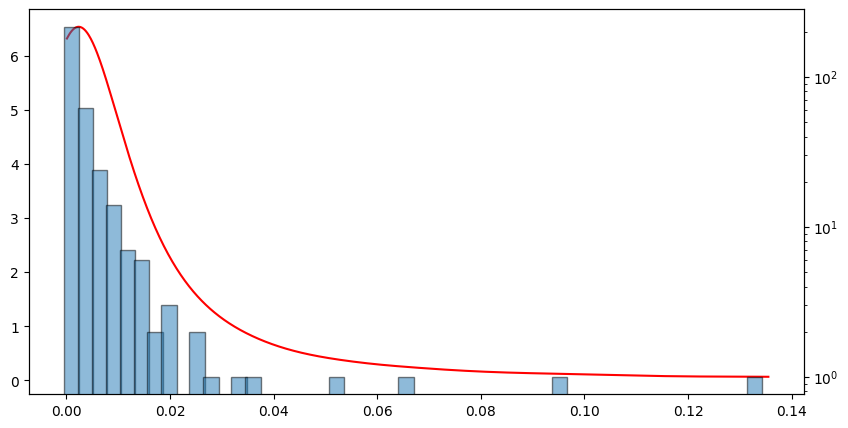

In [879]:
f, ax = plt.subplots(ncols=1, figsize=(10, 5))
eig_vals, eig_vecs = eigh(C_tilde)
EVS = eig_vals
kernel = scipy.stats.gaussian_kde(EVS)
xs = np.linspace(0.0001, max(EVS), 1000)
kde_estimates = np.reshape(kernel(xs).T, xs.shape)

gs = [estimated_density(x, EVS, 4*C.shape[0]) for x in xs]

#_ = ax.plot(xs, kde_estimates, color="green")
_ = ax.plot(xs, gs, color='red')
ax2 = ax.twinx()

filtered_eigs = eig_vals[eig_vals > 0.001]
h, e = np.histogram(filtered_eigs, bins=50)

ax2.bar(e[:-1], h, width=0.003, edgecolor='k', alpha=0.5)
ax2.set_yscale('log')

### Remove market portfolio from covariance matrix (and noise eigenvalues?). Then get the trace and frobenius and check if curve is different:

In [621]:
eig_vals = eig_vals.real

In [622]:
market_portfolio = eig_vecs[:, -1]/sum(eig_vecs[:, -1]) @ df.T

In [623]:
market_weighting = eig_vecs[:, -1]/sum(eig_vecs[:, -1])
effective_n_stocks = 1/sum(market_weighting**2)
effective_n_stocks

440.21696433449887

In [624]:
M = market_portfolio.to_numpy().reshape(-1, 1)
PROJ_M = np.diag([1]*M.shape[0]) - M @ np.linalg.inv(M.T @ M) @ M.T

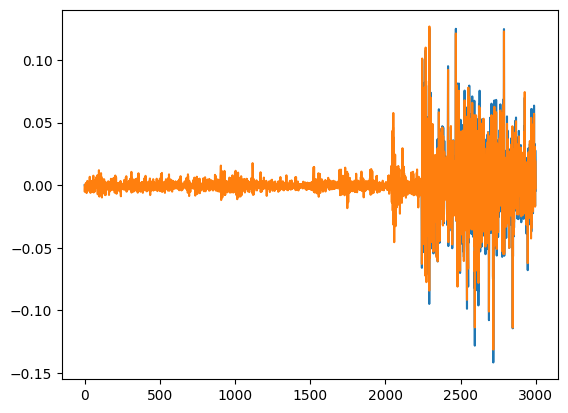

In [625]:
plt.plot(df.iloc[:, 5:6].values)
plt.plot(PROJ_M @ df.iloc[:, 5:6])

In [740]:
idio_df = PROJ_M @ df
c_props = idio_df.pipe(rolling_pipe, 5, my_f)

Text(0, 0.5, 'Y2 data')

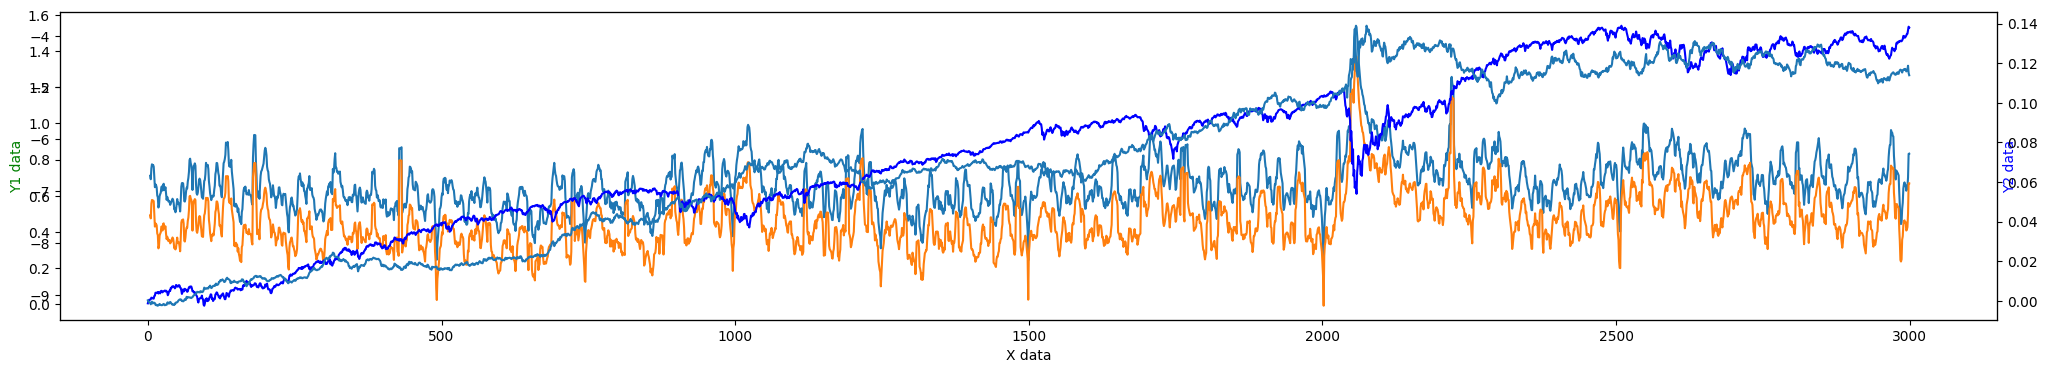

In [741]:
fig, ax1 = plt.subplots(figsize=(25, 4))

ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax1.plot(c_props.iloc[:, :2].apply(lambda x: np.log(x)))
ax2.plot(market_portfolio.cumsum().values, 'b-')
ax3.plot(idio_df.mean(axis=1).cumsum().values)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')

In [742]:
from scipy.fft import fft, fftfreq

In [743]:
y = c_props.iloc[:, 1].dropna()
N = y.shape[0]

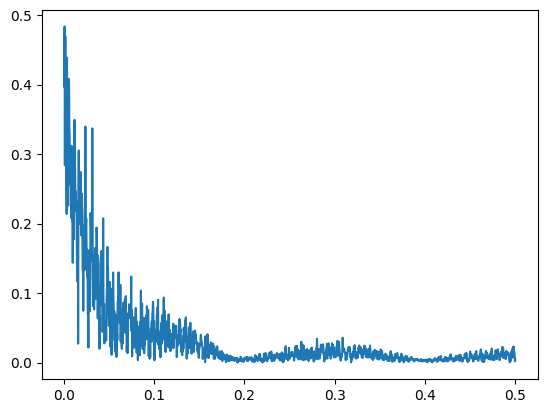

In [746]:
yf = fft(y.values)
xf = fftfreq(N, 1)
plt.plot(xf[2:N//2], 2*np.abs(yf[2:N//2]))

In [747]:
f, Pxx = scipy.signal.periodogram(y, window='parzen')

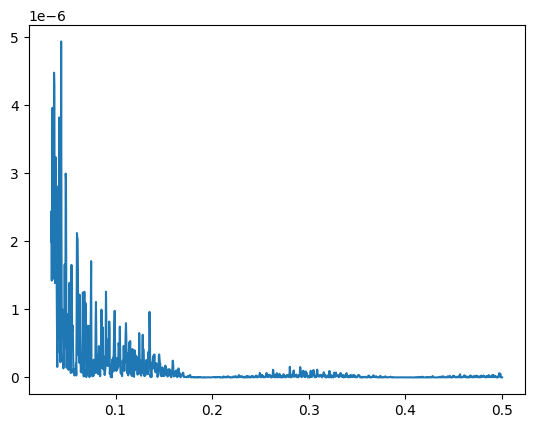

In [751]:
_ = plt.plot(f[100:], Pxx[100:])

In [717]:
from spectrum import Periodogram

In [719]:
p = Periodogram(y)

In [720]:
p()

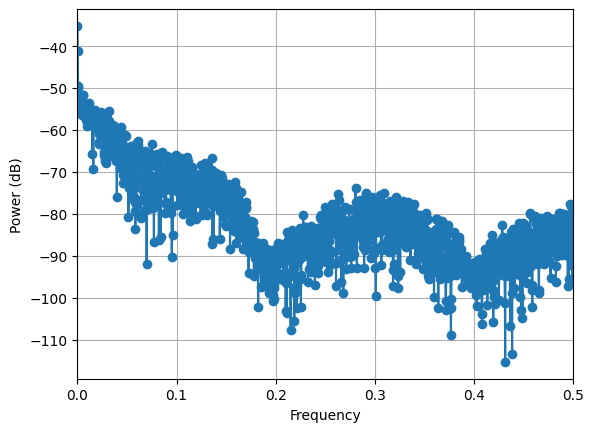

In [721]:
p.plot(marker='o')